In [31]:
import os
from tqdm import tqdm
from time import time
import pandas as pd
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit, Aer, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import StabilizerState, Pauli, DensityMatrix, Statevector, Operator
from qiskit.quantum_info.operators.symplectic.clifford import Clifford
from qiskit.circuit.quantumcircuitdata import CircuitInstruction
from qiskit.circuit.operation import Operation
from qiskit_aer import aerbackend, aerprovider
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, QuantumError, pauli_error
import matplotlib.pyplot as plt
import sys
import numpy as np
from collections import defaultdict
from qiskit.quantum_info import state_fidelity
np.random.seed(239)
import seaborn as sns
directory_path='QASMBench/'

In [32]:
native_gates = ['rz', 'cz', 'rx', 'ry']

In [33]:
def remove_conditions(circuit : QuantumCircuit):
    circ = QuantumCircuit(*circuit.cregs, *circuit.qregs)
    circ.name = circuit.name
    for instr, qargs, cargs in circuit.data:
        if (instr.condition is None):
            circ.append(instr, qargs, cargs)
    return circ

In [34]:
def round_to_pi2(angle):
    normalized_angle = angle % (2 * np.pi)
    rounded_angle = (normalized_angle // (np.pi / 2)) * (np.pi / 2)
    return rounded_angle

def round_angles(circuit):
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    angle = 0
    for instr, qargs, cargs in circuit.data:
        if (instr.name == 'rz'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.rz(angle, qargs) if angle else 0
        elif(instr.name == 'rx'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.rx(angle, qargs) if angle else 0
        elif(instr.name == 'ry'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.ry(angle, qargs) if angle else 0
        else:
            new_circuit.append(instr, qargs, cargs)
    return new_circuit

In [35]:
def get_duration_prob(name, params, T2=2000, T_RX=100, T_RZ=30, T_CZ=15): #mks
    if (name == 'rx' or name == 'ry'):
        theta = params[0] % (2 * np.pi)
        return theta / np.pi * 5, 1 - np.exp(-theta / T_RX / np.pi)
    if (name == 'rz'):
        theta = params[0] % (2 * np.pi)
        return theta / np.pi * 0.5, 1 - np.exp(-theta / T_RZ / np.pi)
    if (name == 'cz'):
        return 2, 1 - np.exp(-2. / T_CZ)
    if (name == 'id'):
        if len(params):
            t = params[0]
            return t, 1 - np.exp(-t/T2)
        return 0, 0
    return None

def make_native_circuit(t_circ : QuantumCircuit, opt_level=0, T2=2000, T_RX=100, T_RZ=30, T_CZ=15) -> (QuantumCircuit, dict):
    circuit = transpile(t_circ, basis_gates=native_gates, optimization_level=opt_level)
    time = 0.0 #mks
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    new_circuit.name = t_circ.name
    data = []
    num_instr = 0
    times = np.zeros(circuit.num_qubits)
    for instr, qargs, cargs in circuit.data:
        if (instr.name in native_gates):
            for qarg in qargs:
                index = circuit.find_bit(qarg).index     
                # id gate:
                if times[index] != time:
                    new_circuit.id(qarg)
                    duration_id, prob_id = get_duration_prob('id', [time - times[index]], T2=T2)
                    data.append(prob_id)
                    times[index] = time
            # gate:
            duration, prob = get_duration_prob(instr.name, instr.params, T2=T2, T_RX=T_RX, T_RZ=T_RZ, T_CZ=T_CZ)
            new_circuit.append(instr, qargs, cargs)
            data.append(prob)
            time = time + duration
            for qarg in qargs:
                times[index] = time
    for qreg in new_circuit.qregs:
        for qarg in qreg:
            index = new_circuit.find_bit(qarg).index
            if times[index] != time:
                new_circuit.id(qarg)
                duration, prob = get_duration_prob('id', [time - times[index]], T2=T2)
                data.append(prob)        
    return new_circuit, data

In [36]:
paths = []
for root, dirs, files in os.walk(directory_path):
    for dir_name in dirs:
        qasm_file_path = os.path.join(directory_path, dir_name, f"{dir_name}.qasm")
        number_at_end = int(''.join(filter(str.isdigit, dir_name)))
        if os.path.exists(qasm_file_path) and number_at_end <= 7:
            paths.append(qasm_file_path)
def noisy_circuit(circuit, data):
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    assert(len(circuit.data) == len(data))
    for i, (instr, qargs, cargs) in enumerate(circuit.data):
        prob_error = data[i]
        choice = np.random.choice(['Z', 'I'], p=[prob_error, 1 - prob_error])
        new_circuit.append(instr, qargs, cargs)
        if (choice == 'Z'):
            new_circuit.z(qargs)
    return new_circuit

In [37]:
def make_clifford_data(circ : QuantumCircuit, data : list = None, round_angle : bool =False):
    if not round_angle or not data:
        c, data = make_native_circuit(round_angles(circ), opt_level=0)
    else:
        c = circ
    new_circuit = QuantumCircuit(*c.qregs, *c.cregs)
    new_data = []
    for i, (instr, qargs, cargs) in enumerate(c.data):
        if (instr.name == 'rz'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.s(qargs)
                new_data.append(data[i])
            elif (angle == np.pi):
                new_circuit.z(qargs)
                new_data.append(data[i])
            elif (angle == 3 * np.pi / 2):
                new_circuit.s(qargs)
                new_circuit.z(qargs)
                new_data.append(0)
                new_data.append(data[i])
        elif (instr.name == 'rx'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
            elif (angle == np.pi):
                new_circuit.x(qargs)
                new_data.append(data[i])
            elif (angle == 3 * np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.x(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
        elif (instr.name == 'ry'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
            elif (angle == np.pi):
                new_circuit.y(qargs)
                new_data.append(data[i])
            elif (angle == 3 * np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.y(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(data[i])
        else:
            new_circuit.append(instr, qargs, cargs)
            new_data.append(data[i])
    return new_circuit, new_data

In [38]:
def make_clifford(circ : QuantumCircuit, round_angle : bool =False) -> Clifford:
    if not round_angle:
        transpile_circuit = round_angles(circ)
    else:
        transpile_circuit = circ
    new_circuit = QuantumCircuit(*transpile_circuit.qregs, *transpile_circuit.cregs)
    close = lambda a, b : np.abs(a - b) < 1e-6
    for instr, qargs, cargs in transpile_circuit.data:
        if (instr.name == 'rz'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.z(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.s(qargs)
                new_circuit.z(qargs)
        elif (instr.name == 'rx'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
            elif (angle == np.pi):
                new_circuit.x(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.x(qargs)
        elif (instr.name == 'ry'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.y(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.y(qargs)
        else:
            new_circuit.append(instr, qargs, cargs)
    new_circuit.save_clifford()
    aer = AerSimulator(method='stabilizer')
    result = aer.run(new_circuit, shots=1).result().data()['clifford']
    return result, new_circuit

In [39]:
circuits = []
for i, path in enumerate(paths):    
    filename = path.split('/')[-1]
    sys.stdout.flush()
    circuit = QuantumCircuit.from_qasm_file(path)
    circuit.name = filename[:-5]
    circuit = remove_conditions(circuit)
    circuit.remove_final_measurements()
    #circuit = round_angles(circuit)
    circuits.append(make_native_circuit(circuit, opt_level=2))

In [40]:
def fidelity_clifford_long(clifford1 : Clifford, clifford2 : Clifford) -> complex:
    d = 2 ** clifford1.num_qubits
    initial_state = np.zeros(d)
    initial_state[0] = 1
    initial_state = initial_state.reshape(d, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state2 = clifford2.to_matrix() @ initial_state
    return state_fidelity(state1, state2)

In [41]:
#to plot circuits
#plt.figure(figsize=(100, 5))
# circ, d = make_native_circuit(round_angles(circuits[12][0]), opt_level=0)
# n_circ = noisy_circuit(circ, d)
# fig, axs = plt.subplots(3, 1, figsize=(100, 8), gridspec_kw={'hspace': 0.001})
# circuit_drawer(circuits[12][0], output='mpl', style='iqp', ax=axs[0], scale=2, fold=len(circuits[12][0].data))
# circuit_drawer(circ, output='mpl', style='clifford', ax=axs[1], scale=2, fold=len(circuits[12][0].data))
# circuit_drawer(n_circ, output='mpl', style='clifford', ax=axs[2], scale=2, fold=len(n_circ.data))
# plt.savefig('circ12.pdf')


In [43]:
#to check (measuring -> measure = True)
def fidelity_density_matrix(circuit :QuantumCircuit, T2=2000, T_RX=100, T_RZ=30, T_CZ=15, measure=True):
    circ, d = make_native_circuit(circuit, opt_level=0, T2=T2, T_RX=T_RX, T_RZ=T_RZ, T_CZ=T_CZ)
    noiseless_circ = circ.copy()
    noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    rho1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().data()['density_matrix'])
    

    rho2 = np.zeros_like(rho1)
    rho2[0, 0] = 1
    for i, (instr, qargs, cargs) in enumerate(circ.data):
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.append(instr, qargs, cargs)
        U = Operator(qc).to_matrix()
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.z(qargs)
        Z = Operator(qc).to_matrix()
        rho2 = U @ rho2 @ U.T.conj()
        prob = d[i]
        #rho2 = (1 - prob) * rho2 + prob * np.eye(2 ** circ.num_qubits) / (2 ** circ.num_qubits)
        rho2 = (1 - prob) * rho2 + prob * Z @ rho2 @ Z
    if measure:
        return state_fidelity(np.diag(rho1.diagonal()), np.diag(rho2.diagonal()))
    else:
        return state_fidelity(rho1, rho2)

In [44]:
def fidelity_density_matrix2(circuit :QuantumCircuit, T2=2000, T_RX=100, T_RZ=30, T_CZ=15, measure=True):
    circ, d = make_clifford_data(circuit)
    noiseless_circ = circ.copy()
    noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    rho1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().data()['density_matrix'])
    

    rho2 = np.zeros_like(rho1)
    rho2[0, 0] = 1
    for i, (instr, qargs, cargs) in enumerate(circ.data):
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.append(instr, qargs, cargs)
        U = Operator(qc).to_matrix()
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.z(qargs)
        Z = Operator(qc).to_matrix()
        rho2 = U @ rho2 @ U.T.conj()
        prob = d[i]
        #rho2 = (1 - prob) * rho2 + prob * np.eye(2 ** circ.num_qubits) / (2 ** circ.num_qubits)
        rho2 = (1 - prob) * rho2 + prob * Z @ rho2 @ Z
    if measure:
        return state_fidelity(np.diag(np.abs(rho1.diagonal())), np.diag(np.abs(rho2.diagonal())))
    else:
        return state_fidelity(rho1, rho2)

In [45]:
#to check 2 
def fidelity_long_shots_2(circuit : QuantumCircuit, shots=1000):
    circ, d = make_native_circuit(circuit)
    noiseless_circ = circ.copy()
    noiseless_circ.save_statevector()
    g = AerSimulator(method='statevector')
    phi1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().get_statevector(noiseless_circ))
    phi_all = np.zeros_like(phi1)
    for _ in tqdm(range(shots)):
        noisy_circ = noisy_circuit(circ, d)
        noisy_circ.save_statevector()
        phi2 = np.array(g.run(noisy_circ, shots=1, noise_model=None, optimization_level=0).result().get_statevector(noisy_circ))
        phi_all += np.abs(phi2)**2
    phi_all = np.sqrt(phi_all / shots)

    return state_fidelity(phi_all, np.abs(phi1))

In [46]:
def clifford_simulate(circ :  QuantumCircuit) -> Clifford:
    circuit = circ.copy()
    circuit.save_clifford()
    aer = AerSimulator(method='stabilizer')
    result = aer.run(circuit, shots=1).result().data()['clifford']
    return result

In [47]:
def fidelity(circuit : QuantumCircuit, shots=1000):
    circ, d = make_native_circuit(round_angles(circuit), opt_level=0)
    clifford1, c = make_clifford(circ, round_angle=True)
    fs = []
    clifford2 = 0
    r = 2 ** clifford1.num_qubits
    initial_state = np.zeros(r)
    initial_state[0] = 1
    initial_state = initial_state.reshape(r, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state_all = np.zeros_like(state1)
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(circ, d)
        clifford2, c = make_clifford(noisy, round_angle=True)
        state2 = clifford2.to_matrix() @ initial_state
        state_all += np.abs(state2)**2
        #fs.append(state_fidelity(state1, state2))
    state_all = np.sqrt(state_all / shots)
    #return np.mean(fs), 
    return state_fidelity(state_all, np.abs(state1))

In [48]:
def fidelity2(circuit : QuantumCircuit, shots=1000):
    circ, d = make_clifford_data(circuit)
    clifford1 = clifford_simulate(circ)
    fs = []
    clifford2 = 0
    noisies = []
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(circ, d)
        noisy.save_clifford()
        noisies.append(noisy)
    g = AerSimulator(method='stabilizer')
    result = g.run(noisies, shots=1).result()#.data()['clifford']
    d = 2 ** clifford1.num_qubits
    initial_state = np.zeros(d)
    initial_state[0] = 1
    initial_state = initial_state.reshape(d, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state_all = np.zeros_like(state1)
    for i in tqdm(range(shots)):
        clifford2 = result.data(i)['clifford']
        state2 = clifford2.to_matrix() @ initial_state
        state_all += np.abs(state2)**2
        #fs.append(state_fidelity(state1, state2))
    state_all = np.sqrt(state_all / shots)
    #return np.mean(fs), 
    return state_fidelity(state_all, np.abs(state1))

In [49]:
def fidelity_measuring(circuit : QuantumCircuit, shots=1000):
    c, d = make_clifford_data(round_angles(circuit))
    noiseless = c.copy()
    noiseless.measure_all()
    g = AerSimulator(method='stabilizer')
    result1 = dict(g.run(noiseless, noise_model=None, shots=shots, optimization_level=0).result().data())['counts']
    noisies = []
    result2 = defaultdict(int)
    #for _ in tqdm(range(shots)):
    for _ in range(shots):
        noisy = noisy_circuit(c, d)
        noisy.measure_all()
        noisies.append(noisy)
    results = g.run(noisies, noise_model=None, shots=1, optimization_level=0).result()
    for i in range(shots):
        res = list(results.data(i)['counts'])[0]
        result2[res] += results.data(i)['counts'][res]
    df = pd.DataFrame([result1, result2]).T
    df = df.fillna(0).astype(int)
    state1 = np.array(np.sqrt(df[0] / shots))
    state2 = np.array(np.sqrt(df[1] / shots))
    return state_fidelity(state1, state2)
    #return (np.sum(np.sqrt(df[0] * df[1])) / shots) ** 2

In [50]:
def fidelity_measuring2(circuit : QuantumCircuit, shots=1000):
    c, d = make_native_circuit(round_angles(circuit), opt_level=0)
    noiseless = c.copy()
    noiseless.measure_all()
    #clifford1 = make_cliffor
    #noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    result1 = dict(g.run(noiseless, noise_model=None, shots=shots, optimization_level=0).result().data())['counts']   
    noisies = []
    result2 = defaultdict(int)
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(c, d)
        noisy.measure_all()
        noisies.append(noisy)
    results = g.run(noisies, noise_model=None, shots=1, optimization_level=0).result()
    for i in range(shots):
        res = list(results.data(i)['counts'])[0]
        result2[res] += results.data(i)['counts'][res]
    df = pd.DataFrame([result1, result2]).T
    df = df.fillna(0).astype(int)
    state1 = np.array(np.sqrt(df[0] / shots))
    state2 = np.array(np.sqrt(df[1] / shots))
    return state_fidelity(state1, state2)
    #return (np.sum(np.sqrt(df[0] * df[1])) / shots) ** 2

In [54]:
data = []

def sorting_key(qc):
    return (qc[0].num_qubits, len(qc[0]))

circuits_sorted = sorted(circuits, key=sorting_key)
shots = 10
for circuit, d in circuits_sorted:
    print('\\')
    print(circuit.name)
    shots = 10
    eps = 1
    fid1 = fidelity_density_matrix(round_angles(circuit), measure=True)
    while shots < 2000:
        epses = []
        k = 0
        while (k < 3):
            fid2 = fidelity_measuring(circuit, shots=shots)
            data.append({'circuit' : circuit.name, 
                   'orig_fidelity' : fid1, 
                   'clifford_fidelity' : fid2, 
                    'shots': shots})
            eps = np.abs(fid2 - fid1) / fid1
            epses.append(eps)
            #print(shots, circuit.name, fid1, fid2, eps)
            print(shots, end= ',')
            k += 1
        eps = np.max(epses) if len(epses) else eps
        shots = int(shots * 1.3)

\
deutsch_n2
100,100,100,130,130,130,169,169,169,219,219,219,284,284,284,369,369,369,479,479,479,622,622,622,808,808,808,1050,1050,1050,1365,1365,1365,1774,1774,1774,\
grover_n2
100,100,100,130,130,130,169,169,169,219,219,219,284,284,284,369,369,369,479,479,479,622,622,622,808,808,808,1050,1050,1050,1365,1365,1365,1774,1774,1774,\
iswap_n2
100,100,100,130,130,130,169,169,169,219,219,219,284,284,284,369,369,369,479,479,479,622,622,622,808,808,808,1050,1050,1050,1365,1365,1365,1774,1774,1774,\
quantumwalks_n2
100,100,100,130,130,130,169,169,169,219,219,219,284,284,284,369,369,369,479,479,479,622,622,622,808,808,808,1050,1050,1050,1365,1365,1365,1774,1774,1774,\
ipea_n2
100,100,100,130,130,130,169,169,169,219,219,219,284,284,284,369,369,369,479,479,479,622,622,622,808,808,808,1050,1050,1050,1365,1365,1365,1774,1774,1774,\
dnn_n2
100,100,100,130,130,130,169,169,169,219,219,219,284,284,284,369,369,369,479,479,479,622,622,622,808,808,808,1050,1050,1050,1365,1365,1365,1774,1774,1774,\
telepor

In [56]:
data = data + data2

In [57]:
df = pd.DataFrame(data)
df['qubit_count'] = df['circuit'].apply(lambda c: int(c[-1]))
df['eps'] = np.abs(df['orig_fidelity'] - df['clifford_fidelity']) / df['orig_fidelity']
lens = {c.name : len(c) for c, t in circuits_sorted}
circs = {c.name : c for c, t in circuits_sorted}
def peaks(c1 : QuantumCircuit):
    c = c1.copy()
    g = AerSimulator()
    c.measure_all()
    return len(g.run(c, shots=2000).result().data()['counts'])
peakss = {c.name: peaks(c) for c, t in circuits_sorted}
df['len'] = df['circuit'].apply(lambda c: lens[c])
df['peaks'] = df['circuit'].apply(lambda c: peakss[c])

,circuit,orig_fidelity,clifford_fidelity,shots,qubit_count,eps,len,peaks
0,deutsch_n2,0.861497,0.827047,100,2,0.039988,13,2
1,deutsch_n2,0.861497,0.869959,100,2,0.009822,13,2
2,deutsch_n2,0.861497,0.813100,100,2,0.056178,13,2
3,deutsch_n2,0.861497,0.838295,130,2,0.026932,13,2
4,deutsch_n2,0.861497,0.828231,130,2,0.038615,13,2
...,...,...,...,...,...,...,...,...
2569,hhl_n7,0.500000,0.110079,62,7,0.779842,814,5
2570,hhl_n7,0.500000,0.096073,62,7,0.807853,814,5
2571,hhl_n7,0.500000,0.109808,80,7,0.780384,814,5
2572,hhl_n7,0.500000,0.142431,80,7,0.715138,814,5


<Figure size 2160x720 with 0 Axes>

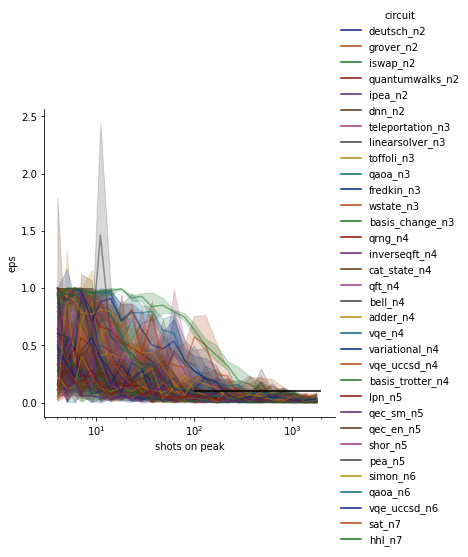

In [58]:
plt.figure(figsize=(30, 10))
df['shots_on_peak'] = df['shots'] / df['peaks']
g = sns.relplot(x='shots', y='eps', hue='circuit', kind='line', data=df, palette='dark', alpha=0.5)

g.set_axis_labels('shots on peak', 'eps')
g.set_titles(col_template='{col_name}')
plt.hlines(y=0.1, xmin=100, xmax=2000, color='black')
plt.xscale('log')
plt.show()

In [66]:
fidelity_long_shots_2(round_angles(circuits[12][0]), shots=5000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.56it/s]


0.5142000000000008

In [67]:
fidelity(round_angles(circuits[12][0]), shots=5000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:04<00:00, 10.32it/s]


0.4997999999999998